In [1]:
from earthai.init import *

from earthai.chipping import chipping_strategies
from earthai.chipping.strategy import CentroidCentered
import pyspark.sql.functions as F
import geopandas
import pandas
from shapely.geometry import Point
import ipyleaflet
import rasterio
from rasterio.plot import show 

import os


Importing EarthAI libraries.
EarthAI version 1.4.3.dev; RasterFrames version 0.9.0; PySpark version 2.4.6

Creating SparkSession...
  SparkSession is available as `spark`.


In [2]:
%%eod
{
    "collections": [
        "landsat8_l1tp"
    ],
    "geo": [
        -81.32080078125001,
        28.86872905602898,
        -81.28234863281251,
        28.90961041665505
    ],
    "max_cloud_cover": 10,
    "start_datetime": "2020-01-01",
    "end_datetime": "2020-08-01"
}

'eod0' with 3 rows

In [3]:
points = [ 
    Point(-81.580217,28.400303),
    Point(-81.548142,28.379772),
    Point(-81.555017,28.35699)]
points_gdf = geopandas.GeoDataFrame({'geometry':points}, )

In [4]:
m = ipyleaflet.Map(center=(28.4, -81.55), zoom=8)

parks_layer = ipyleaflet.GeoData(geo_dataframe=points_gdf, name='centers')
scenes_layer = ipyleaflet.GeoData(geo_dataframe=eod0[['geometry']], name='eod')

lg = ipyleaflet.LayerGroup(layers = (parks_layer, scenes_layer), name='query')
m.add_layer(lg)      
m.add_control(ipyleaflet.LayersControl())
m

Map(center=[28.4, -81.55], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [5]:
cat = geopandas.sjoin(points_gdf, eod0)
cat.geom_type

0    Point
1    Point
2    Point
0    Point
1    Point
2    Point
0    Point
1    Point
2    Point
dtype: object

In [6]:
?spark.read.chip

Signature:
spark.read.chip(
    source,
    catalog_col_names=None,
    geometry_col_name='geometry',
    chipping_strategy='feature_aligned_grid',
    crs_col_name=None,
    extent_col_name=None,
    raster_size_col_name=None,
    band_indexes=None,
    lazy_tiles=True,
    **options,
)
Docstring:
Specialization of the RasterFrames `raster` DataFrame reader which takes a geometry column and a chipping strategy as input.
:param source: a string, list of strings, list of lists of strings, a Pandas DataFrame or a Spark DataFrame giving URIs to the raster data to read.
:param catalog_col_names: required if `source` is a DataFrame or CSV string. It is a list of strings giving the names of columns containing URIs to read.
:param geometry_col_name: name of the columns containing the target geometry to chip against.
:param chipping_strategy: An earthai.chipping.strategy.Strategy class or a string giving the chipping strategy to use. See `chipping_strategies()` for details on all available str

In [7]:
chipping_strategies()

['Intersecting Extent (intersecting_extent): Returns whatever axis-aligned area of the scene intersects with the geometry extent, as a single chip.',
 'Scene-aligned Grid (scene_aligned_grid(chipCols: Int, chipRows: Int)): Returns chips created by gridding the whole scene by `chipDimensions` and filtering out ones not intersecting the target geometry.',
 'Feature-aligned Grid (feature_aligned_grid(chipCols: Int, chipRows: Int)): Returns chips created by gridding the intersection area between the scene and target geometry by `chipDimensions`.',
 'Centered on geometry centroid (centroid_centered(chipCols: Int, chipRows: Int)): Returns chips that are centered on the centroid of the target geometry']

In [8]:
earth_ondemand.bands(cat.collection.unique())

,band_name,bundleable,eo_common_name,eo_gsd,roles,title,type,collection_id
0,B5,True,nir,30.0,[data],Band 5 - Near Infrared (NIR) - 851-879nm (30m),image/tiff,landsat8_l1tp
1,thumb_large,True,NaN,NaN,[preview],Thumbnail - Large,image/jpeg,landsat8_l1tp
2,thumb_small,True,NaN,NaN,[thumbnail],Thumbnail - Small,image/jpeg,landsat8_l1tp
3,B9,True,cirrus,30.0,[data],Band 9 - Cirrus - 1363-1384nm (30m),image/tiff,landsat8_l1tp
4,B6,True,swir16,30.0,[data],Band 6 - Shortwave Infrared (SWIR) 1 - 1566-1651nm (30m),image/tiff,landsat8_l1tp
5,B3,True,green,30.0,[data],Band 3 - Green - 533-590nm (30m),image/tiff,landsat8_l1tp
6,B7,True,swir22,30.0,[data],Band 7 - Shortwave Infrared (SWIR) 2 - 2107-2294nm (30m),image/tiff,landsat8_l1tp
7,B10,True,lwir11,30.0,[data],Band 10 - Thermal Infrared (TIRS) 1 - 10600-11190nm (30m),image/tiff,landsat8_l1tp
8,B2,True,blue,30.0,[data],Band 2 - Blue - 452-512nm (30m),image/tiff,landsat8_l1tp
9,BQA,True,NaN,30.0,[qa],Band QA,image/tiff,landsat8_l1tp


Now create dataframe of chips

In [9]:
df = spark.read.chip(source=cat,
                     catalog_col_names=['B4', 'B3', 'B2', 'B5'],
                     geometry_col_name='geometry',
                     chipping_strategy=CentroidCentered(42),
                    ) \
    .withColumnRenamed('B4', 'red') \
    .withColumnRenamed('B3', 'grn') \
    .withColumnRenamed('B2', 'blu') \
    .withColumnRenamed('B5', 'nir') \
    .withColumn('train_test',
                F.when(F.rand() > 0.6, 'test').otherwise('train')) \
    .withColumn('class_label', 
                F.when(F.rand() > 0.5, 1).otherwise(0)) \
    .cache() # DF is small and we will do many actions

In [10]:
df.count(), len(cat)  # expect 3 scenes x 3 geoms, same as len(cat)

(9, 9)

In [11]:
df.groupby(rf_dimensions('red')).count().toPandas()

,rf_dimensions(red),count
0,"(42, 42)",9


## Chip writer

Now demonstrate writing chips to a local directory

In [12]:
?df.write.chip

Signature:
df.write.chip(
    path: str,
    filename: str,
    catalog: bool = True,
    metadata: Union[List[str], NoneType] = None,
)
Docstring:
Write the
:param df_writer:  self
:param path: directory to write to
:param filename: a column name giving the filename to use, possibly including a directory structure.
            Example expression `F.concat_wc('/', train_test, category_label, F.monotonically_increasing_id())`
:param catalog: if True, write a CSV file directory for chips written out
:param metadata: a list of column names to write in the catalog CSV file
:return: None
File:      /opt/conda/envs/earthai/lib/python3.7/site-packages/earthai/__init__.py
Type:      method


In [13]:
# create a column of filenames. These can have unix path separator in them to make subdirectories.
# here we use monotonically_increasing_id to get a unique arbitrary name for each row/chip
df = df.withColumn('file_path_name', 
                   F.concat_ws('/', F.col('train_test'), F.monotonically_increasing_id()))
distinct_file_names = df.select('file_path_name').distinct()
assert distinct_file_names.count() == df.count()

In [14]:
df.write.chip('test_chip_writer', filename='file_path_name', 
              catalog=True, 
              metadata=['id', 'class_label', 'train_test', 'geometry', 'datetime', ])

In [15]:
! ls -lR test_chip_writer/

test_chip_writer/:
total 12
-rw-r--r-- 1 jovyan 40009 1609 Aug  4 14:05 catalog.csv
drwxr-sr-x 2 jovyan 40009 6144 Aug  4 14:05 test
drwxr-sr-x 2 jovyan 40009 6144 Aug  4 14:05 train

test_chip_writer/test:
total 64
-rw-r--r-- 1 jovyan 40009 15765 Aug  4 14:05 1168231104512.tif
-rw-r--r-- 1 jovyan 40009 15849 Aug  4 14:05 1382979469312.tif
-rw-r--r-- 1 jovyan 40009 15853 Aug  4 14:05 1606317768704.tif
-rw-r--r-- 1 jovyan 40009 15500 Aug  4 14:05 764504178688.tif

test_chip_writer/train:
total 80
-rw-r--r-- 1 jovyan 40009 15598 Aug  4 14:05 1159641169920.tif
-rw-r--r-- 1 jovyan 40009 15864 Aug  4 14:05 1597727834112.tif
-rw-r--r-- 1 jovyan 40009 15435 Aug  4 14:05 541165879296.tif
-rw-r--r-- 1 jovyan 40009 15513 Aug  4 14:05 755914244096.tif
-rw-r--r-- 1 jovyan 40009 15537 Aug  4 14:05 936302870528.tif


Dig into one of the chips. It carries a lot of metadata on it. Note the `metadata` list we passed into the writer

test_chip_writer/train/541165879296.tif
driver 		 GTiff
dtype 		 uint16
nodata 		 None
width 		 42
height 		 42
count 		 4
crs 		 EPSG:32617
transform 		 | 30.00, 0.00, 442515.00|
| 0.00,-30.00, 3142335.00|
| 0.00, 0.00, 1.00|

 T A G S :
AREA_OR_POINT 		 Area
base_filename 		 train/541165879296
class_label 		 0
datetime 		 2020-02-27 15:55:23.648218
geometry 		 POINT (-81.580217 28.400303)
id 		 LC08_L1TP_016040_20200227_20200313_01_T1_L1TP
train_test 		 train

 B A N D S :
	Band 1 		 source_column 		 train
	Band 1 		 ColorInterp.red
	Band 2 		 source_column 		 train
	Band 2 		 ColorInterp.green
	Band 3 		 source_column 		 train
	Band 3 		 ColorInterp.blue
	Band 4 		 source_column 		 train
	Band 4 		 ColorInterp.undefined


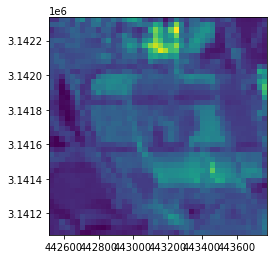

In [16]:
tif = ['test_chip_writer/train/' + f for f in os.listdir('test_chip_writer/train') 
       if f.endswith('tif') ][0]
print(tif)

with rasterio.open(tif) as src:
    for k, v in src.meta.items():
        print(k, '\t\t', v)
        
    print('\n', 'T A G S :')
    for k, v in src.tags().items():
        print(k, '\t\t', v)
        
    print('\n B A N D S :')
    for b in range(1, src.count + 1):
        for k in src.tags(b):
            print("\tBand", b, '\t\t', k, '\t\t', v)
        print("\tBand", b, '\t\t', src.colorinterp[b-1])
    ax = show(src.read(1), transform=src.transform)

Let's look at the csv file that was written out to the directory. It has the filename of the chip with all the `metadata` columns plus some other goodies.


In [17]:
csv_catalog = pandas.read_csv('test_chip_writer/catalog.csv')

In [18]:
csv_catalog.columns

Index(['filename', 'bbox', 'id', 'class_label', 'train_test', 'geometry',
       'datetime'],
      dtype='object')

In [19]:
csv_catalog

,filename,bbox,id,class_label,train_test,geometry,datetime
0,train/541165879296.tif,[442515.0|3141075.0|443775.0|3142335.0],LC08_L1TP_016040_20200227_20200313_01_T1_L1TP,0,train,POINT (-81.580217 28.400303),2020-02-27 15:55:23.648218
1,train/755914244096.tif,[444975.0|3136245.0|446235.0|3137505.0],LC08_L1TP_016040_20200227_20200313_01_T1_L1TP,1,train,POINT (-81.555017 28.35699),2020-02-27 15:55:23.648218
2,test/764504178688.tif,[445635.0|3138765.0|446895.0|3140025.0],LC08_L1TP_016040_20200227_20200313_01_T1_L1TP,1,test,POINT (-81.548142 28.379772),2020-02-27 15:55:23.648218
3,train/936302870528.tif,[442515.0|3141075.0|443775.0|3142335.0],LC08_L1TP_016040_20200314_20200325_01_T1_L1TP,1,train,POINT (-81.580217 28.400303),2020-03-14 15:55:16.921806
4,train/1159641169920.tif,[444975.0|3136245.0|446235.0|3137505.0],LC08_L1TP_016040_20200314_20200325_01_T1_L1TP,1,train,POINT (-81.555017 28.35699),2020-03-14 15:55:16.921806
5,test/1168231104512.tif,[445635.0|3138765.0|446895.0|3140025.0],LC08_L1TP_016040_20200314_20200325_01_T1_L1TP,1,test,POINT (-81.548142 28.379772),2020-03-14 15:55:16.921806
6,test/1382979469312.tif,[442515.0|3141075.0|443775.0|3142335.0],LC08_L1TP_016040_20200501_20200509_01_T1_L1TP,0,test,POINT (-81.580217 28.400303),2020-05-01 15:54:52.691813
7,train/1597727834112.tif,[445635.0|3138765.0|446895.0|3140025.0],LC08_L1TP_016040_20200501_20200509_01_T1_L1TP,0,train,POINT (-81.548142 28.379772),2020-05-01 15:54:52.691813
8,test/1606317768704.tif,[444975.0|3136245.0|446235.0|3137505.0],LC08_L1TP_016040_20200501_20200509_01_T1_L1TP,1,test,POINT (-81.555017 28.35699),2020-05-01 15:54:52.691813


## Chip writing conclusion

Next steps will be to create a data generator in [PyTorch](https://pytorch.org/docs/stable/data.html) or [Keras](https://keras.io/api/preprocessing/image/).

## Slippy map writer

Let's read the catalog again but this time read the entirety of a single scene. We'll subset this to be able to show a lot of different options quickly.

In [20]:
df2 = spark.read.raster(cat.head(1),
                        catalog_col_names=['B4', 'B3', 'B2', 'B5'],
                    ) \
    .withColumnRenamed('B4', 'red') \
    .withColumnRenamed('B3', 'grn') \
    .withColumnRenamed('B2', 'blu') \
    .withColumnRenamed('B5', 'nir') \
    .filter(
        st_intersects(
            st_reproject(rf_geometry('red'), rf_crs('red'), rf_mk_crs('epsg:4326')),
            st_geomFromWKT(F.lit("POLYGON((-81.58825278434438 28.695817228513512,-81.20098471793813 28.695817228513512,-81.20098471793813 28.244321125520017,-81.58825278434438 28.244321125520017,-81.58825278434438 28.695817228513512))"))
          )) \
    .cache() # again because it is small

There are several options for writing slippy map. 

1. You can use `<dataframe>.write.slippy` to write optionally a standalone HTML page with leaflet map embedded into it. NB this is not as directly useful for the notebook environment.
2. Extension method `<dataframe>.to_map` that will write a single layer and return a ipyleaflet Map widget in the output cell
3. Extension method `<dataframe>.to_map_layers` will write several layers. Each layer can be configured separately.

All of these have a variety of options:

1. Write three-band color composite or single band
2. For single band, color ramp to use. See `earthai.valid_color_ramps()`.
2. Writing mode: 
   1. fast by default. Each tile is rendered independently. 
   1. `uniform_color`  makes an additional pass over the data to map values to colors consistently across all tiles

In [21]:
earthai.valid_color_ramps()

['LightYellowToOrange', 'GreenToRedOrange', 'Plasma', 'Greyscale64', 'HeatmapDarkRedToYellowWhite', 'Viridis', 'LightToDarkSunset', 'BlueToRed', 'HeatmapLightPurpleToDarkPurpleToWhite', 'Greyscale256', 'HeatmapYellowToRed', 'Greyscale8', 'LightToDarkGreen', 'Greyscale2', 'BlueToOrange', 'Greyscale128', 'Greyscale32', 'Magma', 'HeatmapBlueToYellowToRedSpectrum', 'Inferno', 'ClassificationMutedTerrain', 'ClassificationBoldLandUse']

In [22]:
?df2.write.slippy

Signature:
df2.write.slippy(
    path: str,
    colorramp: Union[str, NoneType] = None,
    uniform_color: Optional = None,
    html: Optional = None,
)
Docstring:
Write dataframe contents for a web map view. If only one band column is in the dataframe
then a color map name must be provided

:param df_writer: self
:param path: local directory to use for
:param colorramp: A color map to use in the case of a single tile column,
                see earthai.valid_color_ramps() for valid values to use
:param uniform_color: when True, cell statitics will be computed over all rows before
rendering in order to provide a uniform color mapping.
:param html: if provided evaluates to True, will generate a static HTML page with
                leaflet map control
:return: Returns None
File:      /opt/conda/envs/earthai/lib/python3.7/site-packages/earthai/__init__.py
Type:      method


In [ ]:
df2.write.slippy('test_writer_slippy', html=True)

In [ ]:
! ls -l test_writer_slippy

Now lets try the dataframe extension methods.

Simplest method is a single parameter which is the name of the layer. The function returns an `ipyleaflet.Map`

In [ ]:
df2.to_map('to_map')

What happened? It has interpreted one of our bands as an "alpha" or transparency band. 😫 Not exactly what we wanted. Let's take a look at our schema. 4 "projected raster" tile columns. 

In [ ]:
df2.printSchema()

Select down to a single band and map that with famous `Viridis` color ramp

In [ ]:
m_nir = df2.select('nir').to_map('nir_only_vir', color_ramp='Viridis')

In [ ]:
m_nir

We can also pass exactly three tile columns in to generate a color composite.

Note that each of these operations takes a while to run... Let's use the `to_map_layers` to do a bunch of layers all at once.

We pass in a list of dict. Each item in the list will result in a single layer. The value under `columns` key in the dict will control what dataframe columns are considered. These can be tiles, extents, crs, or projected raster. Notice how we can use this to map across columns that may have different extent and crs.

In [ ]:
?df2.to_map_layers

In [ ]:
m3 = df2.withColumn('ndvi', rf_normalized_difference('nir', 'red')) \
    .to_map_layers([
    dict(name='ndvi', columns='ndvi', color_ramp='ClassificationMutedTerrain', uniform=True),
    dict(name='false_color', columns=['nir', 'red', 'grn']),
         
    ])

In [ ]:
m3

Since `m3` is a `Map` object we can change it and view it in multiple panes. 

Let's add our geometry from above to it just for kicks.


In [ ]:
m3.add_layer(parks_layer)

💥‼️

We can also get the layers from our other maps that we have written out. This is super important because writing the layer out again is slow.

In [ ]:
m_nir.layers

In [ ]:
m3.add_layer(m_nir.layers[-1])